# Multi-Fidelity Kriging and Optimization

We are interested in learning a high-fidelity function while using low-fidelity information sources to enhance the model, for that we use Le Gratiet recusrive formultion of multi-fidelity Kriging.

### Kennedy O'Hagan/Le Gratiet recurive formulation:
To perform Le Gratiet's learning, we first learn the lowest fidelity, then we consecutively learn the relationship between every two consecutive fidelity levels (scaling factor $\rho_{k-1}$ and discrepancy function $\delta_k(\cdot)$).

$\mu_{k} = \rho_{k-1}\;\mu_{k-1} + \mu_{\delta_k}\\
\sigma^2_{k} = \rho_{k-1}^2\;\sigma^2_{k-1}+\sigma^2_{\delta_k}$

![Multi-Fidelity 1-D toy problem](co-krigeage.png)

This generally results in a better surrogate model compared to training the high-fidelity alone.

### SMT 
SMT is a joint library between NASA, UoM, ONERA and ISAE-SUPAERO. It offers many surrogate modeling tools with a focus on derivatives. Le Gratiet's formulation was implemented as part of SMT.

After dowmloading and installing SMT library from: https://github.com/SMTorg/smt
We import the needed packages

In [1]:
from smt.extensions import MFK
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
#defining low and high fidelity functions
def LF_function(x):
    return 0.5*((x*6-2)**2)*np.sin((x*6-2)*2)+(x-0.5)*10. - 5

def HF_function(x):
    return ((x*6-2)**2)*np.sin((x*6-2)*2)

Text(0,0.5,u'$y$')

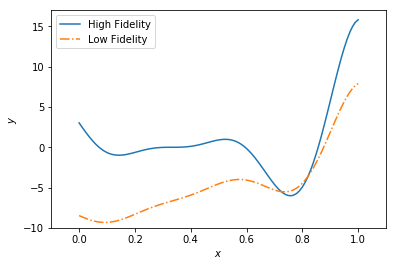

In [3]:
# Ploting High and low fidelity functions

x = np.linspace(0, 1, 101, endpoint = True).reshape(-1,1)
plt.figure()

plt.plot(x, HF_function(x), label ='High Fidelity')
plt.plot(x, LF_function(x), linestyle = '-.' , label ='Low Fidelity')

plt.legend(loc=0)
plt.ylim(-10,17)
plt.xlim(-0.1,1.1)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')


#### Sampling
The idea when building a mutli-fidelity design of experiment is to cover as much space as possible with low-fidelity data and use enough high fidelity samples to learn the relationship between fidelity-levels.

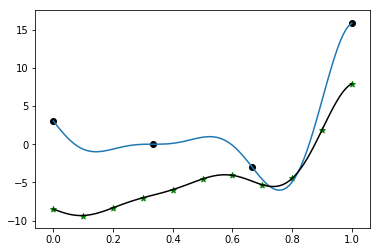

In [4]:
#Linear sampling
ndim=1
Xt_e = np.linspace(0,1, 4, endpoint = True).reshape(-1,ndim)
Xt_c = np.linspace(0,1, 11, endpoint = True).reshape(-1,ndim)

# Evaluate the HF and LF functions
yt_e = HF_function(Xt_e)
yt_c = LF_function(Xt_c)

plt.plot(x, HF_function(x), label ='High Fidelity')
plt.plot(x, LF_function(x) , c ='k', label ='Low Fidelity')
plt.scatter(Xt_e, yt_e, marker = 'o' , color ='k', label ='HF doe')
plt.scatter(Xt_c, yt_c, marker = '*' , color ='g', label ='LF doe')


Building an smt object has many options, you can check all the options in the doc website: http://smt.readthedocs.io

In [5]:
# build the MFK object 
sm = MFK(theta0=np.array(Xt_e.shape[1]*[1.]))

# low-fidelity dataset names being integers from 0 to level-1
sm.set_training_values(Xt_c, yt_c, name = 0) 
# high-fidelity dataset without name
sm.set_training_values(Xt_e, yt_e) 

# train the model
sm.train()

# test training
x = np.linspace(0, 1, 101, endpoint = True).reshape(-1,1)

# query the outputs
y = sm.predict_values(x)

___________________________________________________________________________
   
                                    MFK
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 4
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.0400000
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 101
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   
   Prediction time/pt. (sec) :  0.0000000
   


Text(0,0.5,u'$y$')

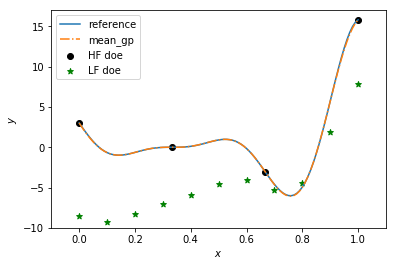

In [6]:
# plot the outputs 
plt.plot(x, HF_function(x), label ='reference')
plt.plot(x, y, linestyle = '-.' , label ='mean_gp')
plt.scatter(Xt_e, yt_e, marker = 'o' , color ='k', label ='HF doe')
plt.scatter(Xt_c, yt_c, marker = '*' , color ='g', label ='LF doe')

plt.legend(loc=0)
plt.ylim(-10,17)
plt.xlim(-0.1,1.1)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')

In [7]:
# Accessing the variance and derivative of the model
MSE = sm.predict_variances(x)
der = sm.predict_derivatives(x, kx=0)

___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 101
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   
   Prediction time/pt. (sec) :  0.0000000
   


Text(0,0.5,u'$y$')

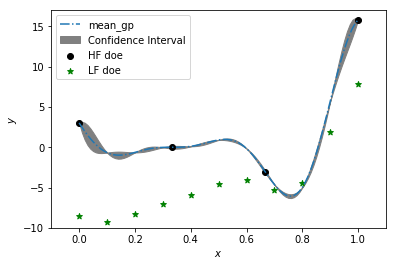

In [8]:
# plot the varaicne 
plt.fill_between(np.ravel(x), np.ravel(y-2*np.sqrt(MSE)), np.ravel(y+2*np.sqrt(MSE)),color='grey' ,label ='Confidence Interval')
plt.plot(x, y, linestyle = '-.' , label ='mean_gp')
plt.scatter(Xt_e, yt_e, marker = 'o' , color ='k', label ='HF doe')
plt.scatter(Xt_c, yt_c, marker = '*' , color ='g', label ='LF doe')

plt.legend(loc=0)
plt.ylim(-10,17)
plt.xlim(-0.1,1.1)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')

## Multi-Fidelity optimization
### Surrogate-based optimization - Bayesian optimization

Bayesian optimization is defined by Jonas Mo\v{c}kus as an optimization technique based upon the minimization of the expected deviation from the extremum of the studied function. 

The objective function is treated as a black-box function. A Bayesian strategy sees the objective as a random function and places a prior over it. The prior captures our beliefs about the behavior of the function. After gathering the function evaluations, which are treated as data, the prior is updated to form the posterior distribution over the objective function. The posterior distribution, in turn, is used to construct an acquisition function (often also referred to as infill sampling criterion) that determines what the next query point should be. One of the possible Infill sampling criteria is the Expected Improvement EI.

#### EI expression:
\begin{align}
E[I(x)] = E[\max(f_{min}-Y, 0)]
\end{align}
where Y is the random variable following the distribution $\mathcal{N}(\mu(x), \sigma^{2}(x))$.
By expressing the Expected Imrpovement as an integral, and applying some tedious integration by parts, one can express the expected improvement in closed form: 

\begin{equation}
E[I(x)] = (f_{min} - \mu(x))\Phi\left(\frac{f_{min} - \mu(x)}{\sigma(x)}\right) + \sigma(x) \phi\left(\frac{f_{min} - \mu(x)}{\sigma(x)}\right)
\end{equation}


In [9]:
import scipy  as sci
def EI_function(model,x):
    x = np.atleast_2d(x)
    Y_min = np.min(model.training_points[None][0][1])
    y_pred = model.predict_values(x)
    mse = modem.predict_variances(x)
    y_pred = np.atleast_2d(y_pred)
    sigma_y = np.sqrt(mse)
    y_normed = (Y_min - y_pred[:,0])/sigma_y
    EI = (Y_min-y_pred[:,0])*sci.stats.norm.cdf(y_normed)+sigma_y*sci.stats.norm.pdf(y_normed)
    return -EI

#### MFEGO:

MFEGO is a two-step decision process:
1. fix most promising point: EI criterion
2. choose levels of enrichment: trade-off information gain/cost
    
By using low-fidelity to reduce the uncertainty we reduce the Exploration contribution to the EI criterion. High-fidelity is used for Exploitation and model enhancement

We compute the uncertainty reduction as: 
\begin{equation*}
\sigma_{red}^{2}(k,x^*) = \sum_{i=0}^k \sigma_{\delta,i}^{2}(x^*) \prod_{j=i}^{l-1} \rho^2_j
\end{equation*}

In [10]:
def ME(lvl, sigma_delta, sigma_rho, theta_vol_lvl, costs, last_val = 0):
    """
    ME : Model enhancement criterion
    """

    MSE_r = last_val + sigma_delta[lvl]*np.product(sigma_rho [lvl:])*theta_vol_lvl[lvl]
    if last_val == 0:
        return True, MSE_r

    return np.log(MSE_r)-np.log(last_val) > 2.*np.log(1+costs[lvl]/costs[lvl-1]), MSE_r

### Example of MFEGO class for two levels of fidelity

In [11]:
class MFEGO():
    """
    Attributes :
        functions, functions from lowest to highest level
    """
    def __init__(self,functions,kriging_model,bounds, costs, multi_start=30):
        self.km = kriging_model
        self.bounds = bounds
        self.n_lvls = 2
        if self.n_lvls != len(functions):
            raise Exception("There must be as many functions as fidelity levels in your Kriging model")
        if self.n_lvls != len(costs):
            raise Exception("There must be as many costs as fidelity levels in your Kriging model")
            
        self.levels = [0, None] ## Highest level has the name None for smt
        self.functions = {0:functions[0], None:functions[1]}
        self.doe_x = {0 : self.km.training_points[0][0][0], None : self.km.training_points[None][0][0]}
        self.doe_y = {0 : self.km.training_points[0][0][1], None : self.km.training_points[None][0][1]}
        self.dim = self.km.nx
        self.costs = np.array(costs)+0.
        self.gain = []
        self.cost_hist =[]
        self.corr_fun = self.km.options['corr']
        self.multi_start = multi_start
        self.y0_best = np.min(self.doe_y[None])
        
    def cost_increment(self, lvls_added):
        # computing the cost increment after each iteration
        # lvls_added list of booleans, True if to be added, False otherwise
        return np.sum(lvls_added * self.costs)/self.costs[-1]
    
    def compute_EI(self,x):
        # compute expected improvement at point x
        x = np.atleast_2d(x)
        Y_min = np.min(self.km.training_points[None][0][1])
        y_pred = self.km.predict_values(x)
        mse = self.km.predict_variances(x)
        y_pred = np.atleast_2d(y_pred)
        sigma_y = np.sqrt(mse)
        y_normed = (Y_min - y_pred[:,0])/sigma_y
        EI = (Y_min-y_pred[:,0])*sci.stats.norm.cdf(y_normed)+sigma_y*sci.stats.norm.pdf(y_normed)
        return -EI
    
    def add_level(self, x):
        MSE, sigma_rho = self.km.predict_variances_all_levels(x)
        
        sigma_delta = np.zeros((self.n_lvls,))
        sigma_rho = np.array(sigma_rho)
        theta_vol_lvl = np.ones((self.n_lvls,))
        flags = self.n_lvls*[False] 
        for lvl in self.levels:
            if lvl is None:
                lvl = self.n_lvls-1
                
            theta_vol_lvl[lvl] = 1.
            if lvl == 0:
                sigma_delta[lvl] = MSE[0, 0]
                flags[lvl], val = ME(lvl, sigma_delta, sigma_rho, theta_vol_lvl, self.costs)
            else:
                sigma_delta[lvl] = MSE[0, lvl]-(MSE[0, lvl-1])*sigma_rho[lvl-1]
                flags[lvl], val = ME(lvl, sigma_delta, sigma_rho, theta_vol_lvl, self.costs, last_val = val)
            if not flags[lvl]:
                break
            
        
        return flags
    
    def run(self, budget):
        self.current_cost = 0 
        n_iter = 0
        first = True
        while self.current_cost<budget: 
            n_iter = n_iter+1
            #optimization of the EI
            candidat = []
            value = []
            dict_cons_1={}
            dict_cons_1['type']='ineq'
            def cons_1(x):
                return -x+self.bounds[:,1]
            dict_cons_1['fun']=cons_1
            dict_cons_2={}
            dict_cons_2['type']='ineq'
            def cons_2(x):
                return x-self.bounds[:,0]
            dict_cons_2['fun']=cons_2
            X0=np.random.rand(self.multi_start,self.dim)
            for i in range(len(self.bounds)):
                X0[:,i]=X0[:,i]*(-self.bounds[i,0]+self.bounds[i,1])+self.bounds[i,0]
            #Multi start    
            for x in X0:
                new_point = sci.optimize.fmin_slsqp(self.compute_EI,np.atleast_2d(x),bounds=self.bounds,iprint=0)
                candidat.append(new_point)
                value.append(self.compute_EI(new_point))
            value = np.array(value)
            
            ind_min = value.argmin()
            x_n = candidat[ind_min].reshape((1,self.dim))
            #Evaluation of the true function(s)
            levels_to_be_added = self.add_level(x_n)     
            for l in self.levels:
                ll = l if l is not None else -1
                if levels_to_be_added[ll]: ## level infill criterion 
                    y_n = self.functions[l](x_n)
                    y_n = np.atleast_2d(y_n)
                #updating the kriging meta-model
                    self.doe_x[l] = np.insert(self.doe_x[l],0,x_n, axis = 0)
                    self.doe_y[l] = np.insert(self.doe_y[l],0,y_n, axis = 0)
                    self.km.set_training_values(self.doe_x[l], self.doe_y[l], name = l )
            #retraining the model
            self.km.train()
            
            # computing cost increment
            self.current_cost = self.current_cost + self.cost_increment(levels_to_be_added)
            
            # saving data for visualization and postprocesing 
            self.cost_hist.append(self.current_cost)
            self.gain.append(self.y0_best-np.min(self.doe_y[None]))
            
            print "######################################"
            print "iteration n=", n_iter
            print "max EI found at x=", x_n
            print "value of the EI =", value.min()
            print "current spent budget: ", self.current_cost
            
        Y_min = np.min(self.doe_y[None])
        return Y_min, self.km   

## Example on Currin Function 
![Multi-Fidelity 1-D toy problem](Currin_function.png)

Source: https://www.sfu.ca/~ssurjano/curretal88exp.html

In [12]:
# -*- coding: utf-8 -*-
"""
Created on Tue May 29 10:43:31 2018

@author: m.meliani
"""


from mpl_toolkits.mplot3d import axes3d
import numpy as np
import matplotlib.pyplot as plt
from smt.extensions.mfk import MFK
from scipy.optimize import rosen
from pyDOE import lhs
from mfk.nested_doe import create_nested_doe
import time
dim = 2
n = [10, 4] # number of low and high-fidelity points
nlevel=2
ub0 = 1.
ub1 = 1.
lb0 = 0.
lb1 = 0.
costs = np.array([1,1000]) # low and high-fidelity costs
initial_cost = np.sum(np.array(n)*costs)

def currin_HF(X):
    # Expensive Currin function
    res = (1-np.exp(-0.5/X[:,1]))*(2300.*X[:,0]**3 + 1900.*X[:,0]**2 + 2092.*X[:,0]+60)/(100.*X[:,0]**3 + 500.*X[:,0]**2 + 4.*X[:,0]+20)
    return -res

def currin_LF(X):
    # Cheap Currin function
    X1= X + 0.05
    X2= np.maximum(X + np.array([0.05,-0.05]), np.array([-np.Inf, 0]))
    X3= X + np.array([-0.05,0.05])
    X4= np.maximum(X -0.05, np.array([-np.Inf, 0]))
    res = 0.25*(currin_HF(X1)+currin_HF(X2)+currin_HF(X3)+currin_HF(X4))
    return res


#np.random.seed(1)
X = create_nested_doe(nlevel=nlevel, dim=2, n_samples=n)
Xc = X[0]
Xe = X[1]


Xe[:,0] = Xe[:,0]*(ub0-lb0)+lb0
Xe[:,1] = Xe[:,1]*(ub1-lb1)+lb1
Xc[:,0] = Xc[:,0]*(ub0-lb0)+lb0
Xc[:,1] = Xc[:,1]*(ub1-lb1)+lb1



yc = currin_LF(Xc)
ye = currin_HF(Xe)

print Xe
print ye

#time.sleep(5)

sm = MFK(theta0=np.array(Xe.shape[1]*[1.]), print_global = False)
sm.set_training_values(Xc, yc, name = 0)
sm.set_training_values(Xe, ye)
sm.train()


bounds=np.array([[lb0,ub0],[lb1,ub1]])
algo_EGO = MFEGO([currin_LF, currin_HF],sm,bounds, costs = costs)
#Running the EGO algorithm for n_iter
budget = 5
Y_min, sm = algo_EGO.run(budget)

target_level = algo_EGO.levels[-1]



[[0.75858837 0.45225317]
 [0.66506542 0.90222724]
 [0.14198996 0.73029654]
 [0.33290383 0.1746103 ]]
[ -7.06769182  -4.62201729  -6.44104439 -12.33107544]
######################################
iteration n= 1
max EI found at x= [[0. 0.]]
value of the EI = -1.3595845847241588
current spent budget:  0.001
######################################
iteration n= 2
max EI found at x= [[0. 1.]]
value of the EI = -1.16828299815374
current spent budget:  0.002
######################################
iteration n= 3
max EI found at x= [[1. 0.]]
value of the EI = -1.0740428519596066
current spent budget:  0.003
######################################
iteration n= 4
max EI found at x= [[3.91414658e-15 2.41072284e-01]]
value of the EI = -1.2888607997762271
current spent budget:  0.004
######################################
iteration n= 5
max EI found at x= [[0.30895984 0.        ]]
value of the EI = -1.9569377631786862
current spent budget:  0.005
######################################
iteration n= 6
max

######################################
iteration n= 46
max EI found at x= [[0.64313612 0.29250642]]
value of the EI = -2.0982156086156127e-79
current spent budget:  1.045999999999996
######################################
iteration n= 47
max EI found at x= [[0.24277808 0.00368536]]
value of the EI = -1.8221383271305347e-22
current spent budget:  1.046999999999996
######################################
iteration n= 48
max EI found at x= [[0.47578879 0.48782402]]
value of the EI = -2.2570948296129225e-14
current spent budget:  1.0479999999999958
######################################
iteration n= 49
max EI found at x= [[0.9073726  0.03651664]]
value of the EI = -2.841780717723705e-46
current spent budget:  1.0489999999999957
######################################
iteration n= 50
max EI found at x= [[0.99615952 0.74151451]]
value of the EI = -3.5295562279395983e-22
current spent budget:  1.0499999999999956
######################################
iteration n= 51
max EI found at x= [[0.00312

######################################
iteration n= 91
max EI found at x= [[0.55304915 0.1910631 ]]
value of the EI = -1.4220810874830728e-58
current spent budget:  1.090999999999991
######################################
iteration n= 92
max EI found at x= [[0.22709417 0.02322068]]
value of the EI = -7.022636026605238e-10
current spent budget:  1.091999999999991
######################################
iteration n= 93
max EI found at x= [[0.38276793 0.99719611]]
value of the EI = -2.522141054118902e-71
current spent budget:  1.0929999999999909
######################################
iteration n= 94
max EI found at x= [[0.66748872 0.40513279]]
value of the EI = -1.1676419459133653e-52
current spent budget:  1.0939999999999908
######################################
iteration n= 95
max EI found at x= [[0.46388038 0.61523697]]
value of the EI = -5.764413376125728e-60
current spent budget:  1.0949999999999906
######################################
iteration n= 96
max EI found at x= [[0.9864808

######################################
iteration n= 136
max EI found at x= [[0.48190248 0.06811707]]
value of the EI = -5.922495833336915e-06
current spent budget:  4.135999999999987
######################################
iteration n= 137
max EI found at x= [[0.17616892 0.02477296]]
value of the EI = -2.0271737990787269e-29
current spent budget:  5.136999999999986


######################################
Optimization summary Currin function
###################################### 





NameError: name 'xv' is not defined

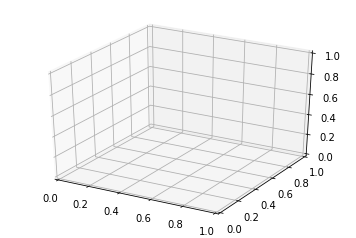

In [13]:
print "######################################"
print "Optimization summary Currin function"
print "###################################### \n\n\n"

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xv, yv, y_test.reshape((50, 50)), label ='surrogate')
#ax.plot_surface(xv, yv, currin_LF(x_test).reshape((50,50)),label ='LF')
ax.plot_surface(xv, yv, currin_HF(x_test).reshape((50,50)),label ='HF reference')

plt.show()

print "######################################"
print "minimum found by ego x=",algo_EGO.doe_x[target_level][algo_EGO.doe_y[target_level].argmin()]," y=",algo_EGO.doe_y[target_level].min()

print "######################################"
print "Initial DOE \n\n\n"
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1.scatter(Xc[:,0],Xc[:,1],\
            marker = 'd', c = "green",s=20, label ='initial cheap DOE')
ax1.scatter(Xe[:,0],Xe[:,1],\
            marker = 'o', c = "blue", s =40, label ='initial expensive DOE')
ax1.legend(loc=0)
plt.show()

print "######################################"
print "Updated DOE : End of Opitmization \n\n\n"
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.scatter(algo_EGO.doe_x[0][:,0],algo_EGO.doe_x[0][:,1],\
            marker = 'd', c = "green",s=20, label ='cheap DOE')
ax2.scatter(algo_EGO.doe_x[None][:,0],algo_EGO.doe_x[None][:,1],\
            marker = 'o', c = "blue", s =40, label ='expensive DOE')
ax2.scatter(algo_EGO.doe_x[target_level][algo_EGO.doe_y[target_level].argmin()][0],\
                           algo_EGO.doe_x[target_level][algo_EGO.doe_y[target_level].argmin()][1],\
                           c='red',marker = '*',s = 80, label ='opt')
ax2.legend(loc=0)

ax1.set_xlim(lb0-0.1,ub0+.1)
ax1.set_ylim(lb1-0.1,ub1+.1)
ax2.set_xlim(lb0-0.1,ub0+.1)
ax2.set_ylim(lb1-0.1,ub1+.1)
plt.show()

print "######################################"
print "Gain figure \n\n\n"
fig3 = plt.figure()
ax3 = fig3.add_subplot(111)
ax3.plot(np.log(np.array(algo_EGO.cost_hist) + initial_cost), algo_EGO.gain, c = "black", marker = "o")
ax3.set_title("Gain vs cost graph")
ax3.set_xlabel("log(Total Cost)")
ax3.set_ylabel("Gain")
plt.show()



#
x = np.linspace(0.,1., 50)
y = np.copy(x)
xv, yv = np.meshgrid(x, y)

x_test= np.array([np.ravel(xv), np.ravel(yv)]).T
y_test = sm.predict_values(x_test)
y_mse = sm.predict_variances



